In [81]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [82]:
def create_sample_data():
    dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
    np.random.seed(42)
    data = {
        'date': dates,
        'product': np.random.choice(['A', 'B', 'C'], len(dates)),
        'quantity': np.random.randint(50, 200, len(dates)),
        'revenue': np.random.uniform(1000, 5000, len(dates))
    }
    ds = pd.DataFrame(data)
    ds.to_csv('sales_data.csv', index=False)
    return ds

In [83]:
def load_and_preprocess_data(file_path='sales_data.csv'):
    try:
        ds = pd.read_csv(file_path)
    except FileNotFoundError:
        ds = create_sample_data()
    ds['date'] = pd.to_datetime(ds['date'])
    ds = ds.fillna({
        'quantity': ds['quantity'].mean(),
        'revenue': ds['revenue'].mean(),
        'product': 'Unknown'
    })
    ds['day_of_year'] = ds['date'].dt.dayofyear
    ds['month'] = ds['date'].dt.month
    ds['year'] = ds['date'].dt.year
    ds['day_of_week'] = ds['date'].dt.dayofweek
    ds = pd.get_dummies(ds, columns=['product'], drop_first=True)
    return ds

In [84]:
def prepare_data(ds):
    features = ['day_of_year', 'month', 'year', 'day_of_week'] + \
               [col for col in ds.columns if col.startswith('product_')]
    x = ds[features]
    y = ds['revenue']
    
    # Scale features
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    
    return x_scaled, y, scaler, features

In [85]:
def train_and_predict(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return model, x_train, x_test, y_train, y_test, y_pred

In [86]:
def predict_future(model, scaler, features, last_date, days=30):
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)
    future_df = pd.DataFrame({
        'date': future_dates,
        'product_A': 1,  # Assuming product A for simplicity
        'product_B': 0,
        'product_C': 0,
        'day_of_year': [d.dayofyear for d in future_dates],
        'month': [d.month for d in future_dates],
        'year': [d.year for d in future_dates],
        'day_of_week': [d.dayofweek for d in future_dates]
    })
    
    X_future = scaler.transform(future_df[features])
    future_predictions = model.predict(X_future)
    
    return future_dates, future_predictions

In [87]:
def plot_results(dates, actual, predicted, future_dates, future_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual Sales', color='blue')
    plt.plot(dates, predicted, label='Predicted Sales', color='red', linestyle='--')
    plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linestyle=':')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Actual vs Predicted Sales with Future Forecast')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [92]:
def display_results(dates, actual, predicted, future_dates, future_predictions):
    results_ds = pd.DataFrame({
        'Date': dates,
        'Actual': actual,
        'Predicted': predicted
    })
    future_ds = pd.DataFrame({
        'Date': future_dates,
        'Actual': [None] * len(future_dates),
        'Predicted': future_predictions
    })
    # Drop columns with all-NA values in future_ds before concatenation
    future_ds = future_ds.dropna(axis=1, how='all')
    combined_ds = pd.concat([results_ds, future_ds], ignore_index=True)
    print("\nSample of Results (first 5 rows and last 5 future predictions):")
    print(combined_ds.head().to_string())
    print("\n...\")
    print(combined_ds.tail().to_string())

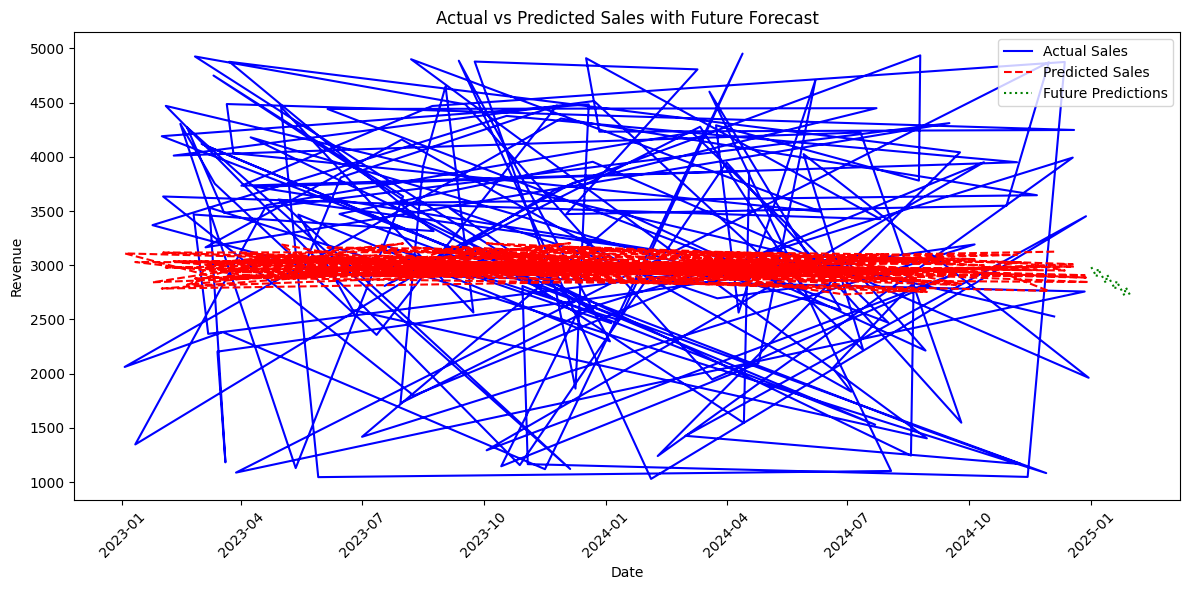


Sample of Results (first 5 rows and last 5 future predictions):
        Date       Actual    Predicted
0 2024-12-04  2527.758559  3125.075486
1 2023-02-03  4469.176804  2978.530825
2 2023-10-28  1157.374163  2941.300626
3 2024-04-01  3947.494980  3011.946918
4 2024-09-25  1548.438823  2827.621076

...
          Date  Actual    Predicted
172 2025-01-26     NaN  2721.430419
173 2025-01-27     NaN  2796.445307
174 2025-01-28     NaN  2774.353239
175 2025-01-29     NaN  2752.261171
176 2025-01-30     NaN  2730.169103


In [93]:
def main():
    ds = load_and_preprocess_data()
    x, y, scaler, features = prepare_data(ds)
    model, x_train, x_test, y_train, y_test, y_pred = train_and_predict(x, y)
    test_dates = ds.iloc[y_test.index]['date']
    last_date = ds['date'].max()
    future_dates, future_predictions = predict_future(model, scaler, features, last_date)
    plot_results(test_dates, y_test, y_pred, future_dates, future_predictions)
    display_results(test_dates, y_test, y_pred, future_dates, future_predictions)
if __name__ == "__main__":
    main()